In [1]:
import requests
import re
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
main_page = 'http://www.angelfire.com/wa/adf/transcripts.html'
main = requests.get(main_page)
soup = BeautifulSoup(main.content, 'html.parser')
links = [x['href'] for x  in soup.body.findAll('a') if len(x['href']) == 8]

In [3]:
df_full = pd.DataFrame()
df_full_lines = pd.DataFrame()

for i in range(len(links)):
    page = requests.get('http://www.angelfire.com/wa/adf/' + links[i])
    soup = BeautifulSoup(page.content, 'html.parser')
    script = soup.body.findAll('p')
    script = [re.sub('[\r\n\xa0]', '', x.text) for x in script]
    script = [re.sub('(\s\s)+', ' ', x).strip() for x in script]
    dialogue = [1 if re.match('[A-Z][a-z]+ - ', x) else 0 for x in script]
    speaker = [re.match('[A-Z][a-z]+ - ', x).group(0)[:-3] if re.match('[A-Z][a-z]+ - ', x) else None for x in script]
    df = pd.DataFrame({'speaker' : speaker, 'script' : script, 'dialogue' : dialogue})
    for i in range(len(df)):
        if df['dialogue'][i] == 1:
            df['script'][i] = df['script'][i][len(df['speaker'][i]) + 3:]
    persons = df['speaker'].unique()[1:]
    lines = [len(df[df['speaker'] == x]) for x in persons]
    df_speaking_lines= pd.DataFrame({'person' : persons, 'lines' : lines}).sort_values('lines', ascending = False).reset_index(drop = True)
    
    df_full = pd.concat([df, df_full])
    df_full_lines = pd.concat([df_speaking_lines, df_full_lines])

/Users/robblatt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [4]:
df_full.reset_index(drop = True, inplace = True)

In [6]:
df_full['wordCount'] = [None] * len(df_full)
for i in range(len(df_full)):
    example = re.sub('[-,"!.]', '', df_full['script'][i])
    df_full['wordCount'][i] = len(re.sub('(\s\s+)', ' ', example).split())

/Users/robblatt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


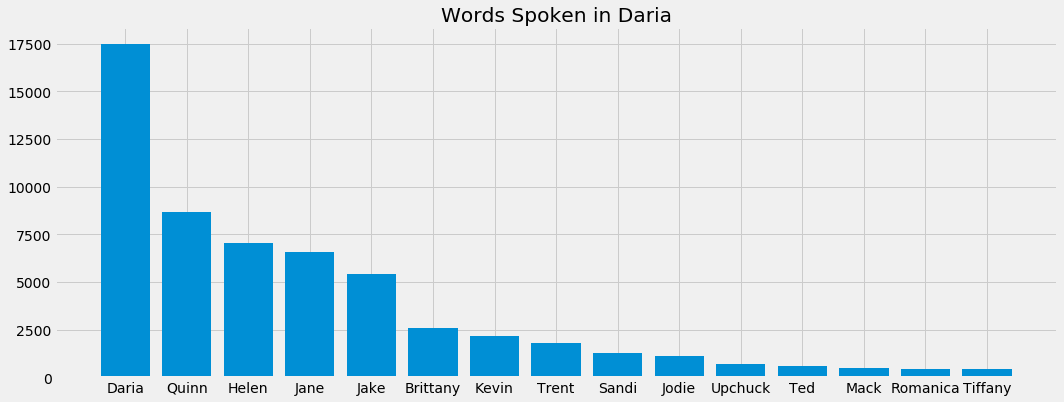

In [7]:
df_words = df_full[['speaker', 'wordCount']].groupby('speaker').sum()

df_words = df_words.sort_values('wordCount', ascending = False)

plt.style.use('fivethirtyeight')
plt.figure(figsize = (16,6))
plt.bar(x = df_words.index[:15], height = df_words['wordCount'][:15])
plt.title('Words Spoken in Daria');

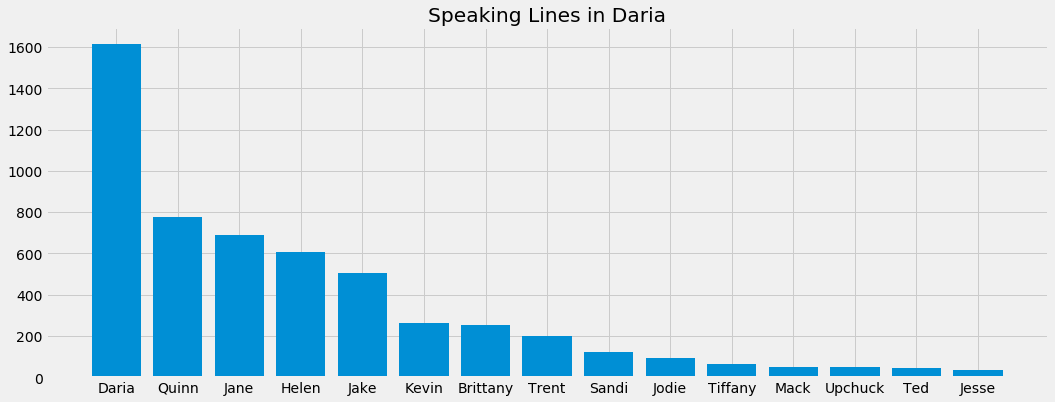

In [8]:
df_full_lines = df_full_lines.groupby('person').sum()
df_full_lines.sort_values('lines', ascending = False, inplace = True)

plt.style.use('fivethirtyeight')
plt.figure(figsize = (16,6))
plt.bar(x = df_full_lines.index[:15], height = df_full_lines['lines'][:15])
plt.title('Speaking Lines in Daria');

In [15]:
from afinn import Afinn
import textwrap

In [27]:
afinn = Afinn()
afinn_score = [afinn.score(x) for x in df_full['script']]

In [29]:
df_full['afinn_score'] = afinn_score

In [41]:
df_full.groupby('speaker').mean().sort_values('afinn_score', ascending = False).drop('dialogue', axis = 1)

,afinn_score
speaker,
Secretary,4.000000
Hele,4.000000
Calvin,4.000000
Minister,3.888889
Teacher,3.222222
...,...
Britttany,-2.500000
Cassidy,-2.666667
Erik,-3.000000


In [38]:
df_full_lines[:25].merge(df_full.groupby('speaker').mean().sort_values('afinn_score', ascending = False).drop('dialogue', axis = 1), how = 'left', left_index = True, right_index = True)

,lines,afinn_score
person,,
Daria,1614.0,0.186493
Quinn,778.0,0.714653
Jane,688.0,0.293605
Helen,606.0,0.554455
Jake,503.0,0.190855
Kevin,265.0,0.313208
Brittany,251.0,0.019920
Trent,198.0,0.368687
Sandi,121.0,0.619835


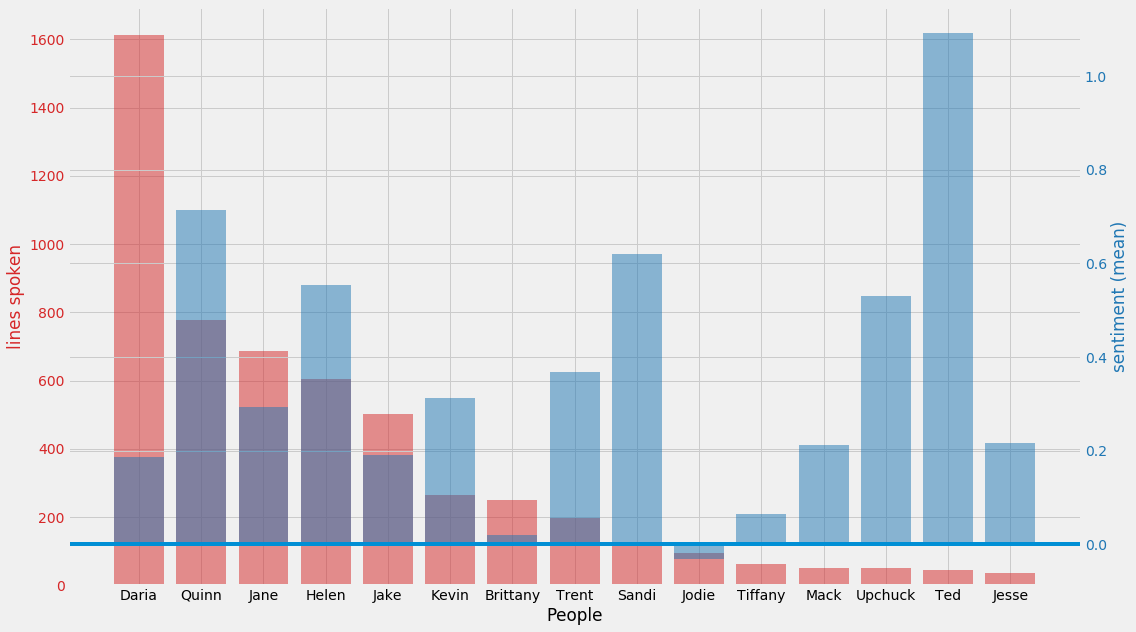

In [55]:
fig, ax1 = plt.subplots(figsize = (16,9))

t = df_full_lines.index[:15]
data1 = df_full_lines[:15].merge(df_full.groupby('speaker').mean().sort_values('afinn_score', ascending = False).drop('dialogue', axis = 1), how = 'left', left_index = True, right_index = True)['lines']
data2 = df_full_lines[:15].merge(df_full.groupby('speaker').mean().sort_values('afinn_score', ascending = False).drop('dialogue', axis = 1), how = 'left', left_index = True, right_index = True)['afinn_score']

color = 'tab:red'
ax1.set_xlabel('People')
ax1.set_ylabel('lines spoken', color=color)
ax1.bar(t, data1, color=color, alpha = 0.5)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('sentiment (mean)', color=color)  # we already handled the x-label with ax1
ax2.bar(t, data2, color=color, alpha = 0.5)
ax2.tick_params(axis='y', labelcolor=color)
ax2.axhline(0)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [85]:
df_full[df_full['wordCount'] > 10]

,speaker,script,dialogue,wordCount,afinn_score
2,None,"""Sick Sad World"" TV Announcer - They broke int...",0,22,-9.0
7,Helen,"Put on your pants, we're seeing more than shou...",1,11,0.0
12,Jake,I'll probably tell them they are right and I a...,1,11,-2.0
15,Quinn,It's such a great I wish I could buy it! I loo...,1,29,7.0
16,None,Mirror Image of Quinn - Put on any shirt or sk...,0,16,1.0
...,...,...,...,...,...
7731,Quinn,So then she stands up in front of the whole sc...,1,19,1.0
7734,Quinn,Ahhh! I'll have to go lock myself in my room u...,1,31,-3.0
7736,Daria,She felt I should have thanked you and mom as ...,1,11,0.0
7737,Helen,"No, we should thank you for being such a great...",1,22,6.0


In [90]:
df_full[df_full['wordCount'] == df_full['wordCount'].max()]['script'][6047]

'She\'ll be coming around the mountain when she comes... she\'ll be coming around the mountain when she comes... Flashback #1: Quinn - (crying) Daria - Can we punish her now? It\'s time for her punishment! Can we punish her now? Babysitter - (sobs) Flashback #2: Quinn - Brain! Daria - Brat! Quinn - Brain! Daria - Brat! Quinn - Brain! Babysitter - Stop that! Stop that! Oh! (drops cane) It\'s my heart! Flashback #3: Daria - You know, she stuffs her bra. Quinn - Hi, I\'m Quinn. I\'ll be allowed to date in four years. Mr. Gupty - Here they are, the little monster! Mrs. Gupty - Lester! We don\'t let sitters use the phone but we made an exception for Quinn after she explained that she calls her Grandmother every hour. Daria - My Grandmother? Mr. Gupty - To tell her to take her pill. Daria - Oh yeah. Actually, tonight it\'s my turn. Mrs. Gupty - Now Daria, here\'s your schedule. As you can see we\'ve broken everything down into fifteen minute increments. Let\'s review it together. Daria - Do 

In [92]:
page = requests.get('http://www.angelfire.com/wa/adf/108.html')

In [94]:
soup = BeautifulSoup(page.content, 'html.parser')
script = soup.body.findAll('p')


In [95]:
script

[<p><font face="Arial" size="2"> </font></p>,
 <p><font face="Arial" size="2">(at school, in Mr. DeMartino's history class) </font></p>,
 <p><font face="Arial" size="2">Mr. DeMartino - And on this fateful day his followers
     obediently drank the poison brew. Jonestown, one charismatic reader exerting his demonic
     will over scores of followers. What lesson can we take from this tragic example of cult
     like behavior? </font></p>,
 <p><font face="Arial" size="2">Kevin - Uh, BUIOB? </font></p>,
 <p><font face="Arial" size="2">Mr. DeMartino - Please return to your stupor Kevin. </font></p>,
 <p><font face="Arial" size="2">Kevin - Okay! </font></p>,
 <p><font face="Arial" size="2">Mr. DeMartino - While we continue our discussion about
     cults. Can anyone give me a modern day example of a cult using cohesive techniques such as
     peer pressure, chanting, and social isolation to control over its members? Brittany! </font></p>,
 <p><font face="Arial" size="2">Brittany - Cheerlea